In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1.json")
data = load_data("../stats/fpm_2_closed_sliding_solver_1.json")

# data = load_data("../stats/fpm_0_sticking_solver_1.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2_closed import make_model
# from fpm_0 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


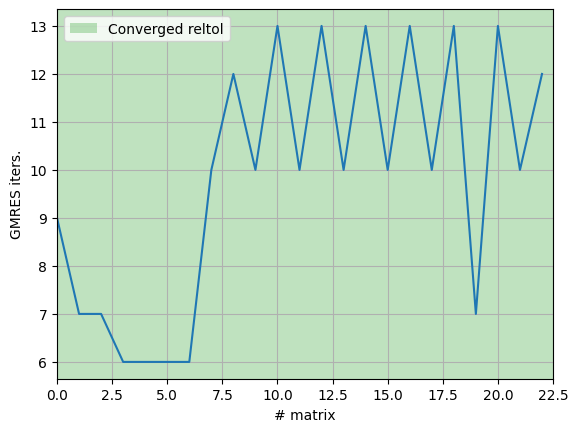

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [6]:
mat_idx = 5
get_gmres_iterations(data)[mat_idx]

6

In [7]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open_[mat_idx])

2 159 7


In [9]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

model.time_manager.dt = dt
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.rediscretize()
model.assemble_linear_system()

assert (model.linear_system[0] - mat).data.size == 0
assert np.all(model.linear_system[1] == rhs)

mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.97


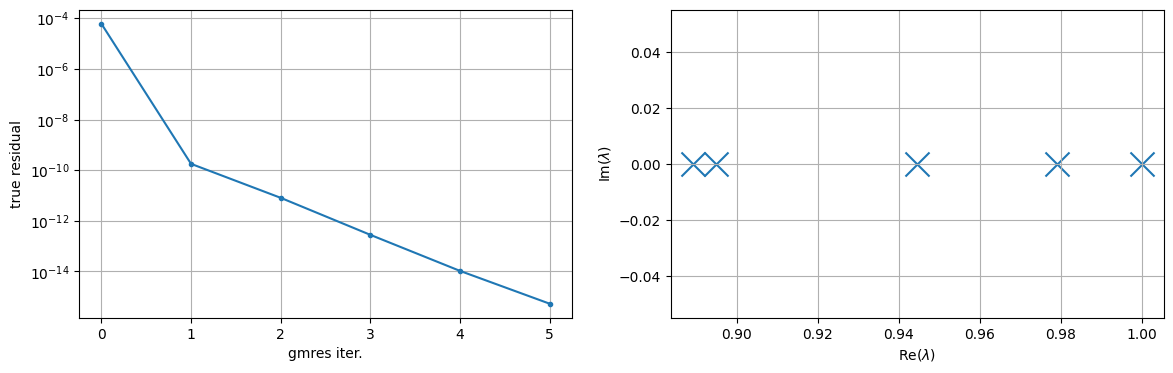

In [10]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

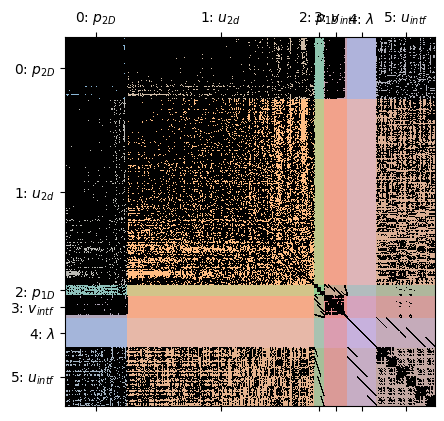

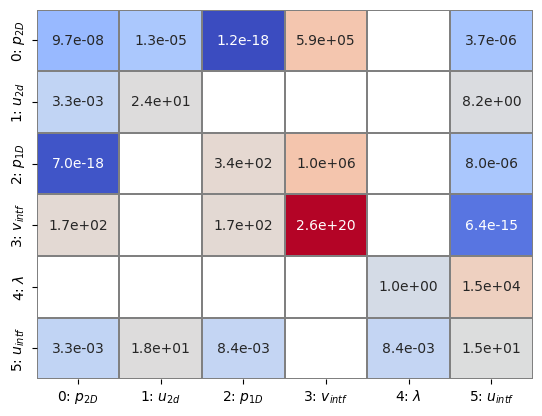

In [11]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

Solve  took: 0.63


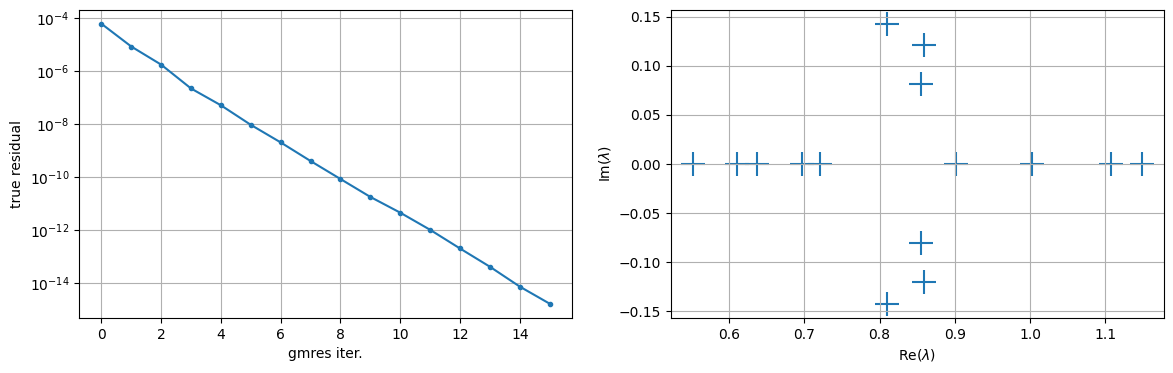

In [13]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv

schema15_amg = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv(model=model, bmat=J),
    complement=schema15_amg,
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

Solve  took: 0.56


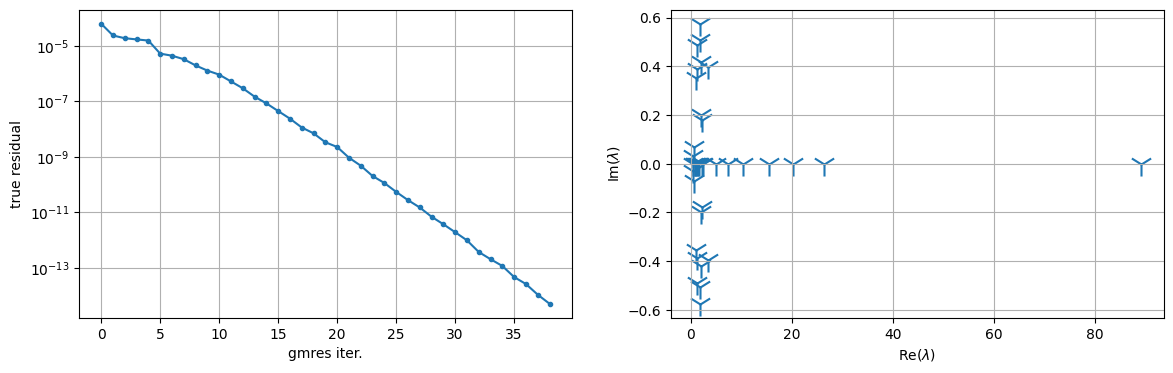

In [14]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization_nd, get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv

schema = SolveSchema(
    groups=[5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),
    # invertor=lambda bmat: scipy.sparse.csr_matrix(bmat.shape),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
        ),
    ),
)


mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

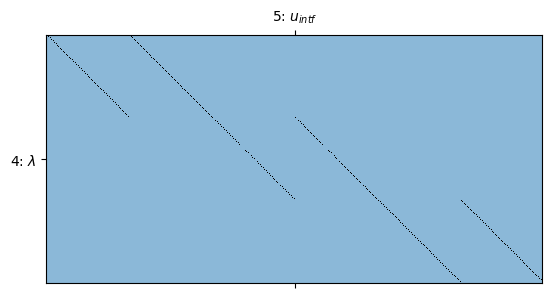

In [15]:
J44 = J[4,4]
J45 = J[4,5]
J54 = J[5,4]
J55 = J[5,5]

J45.color_spy()
# J44.matshow()

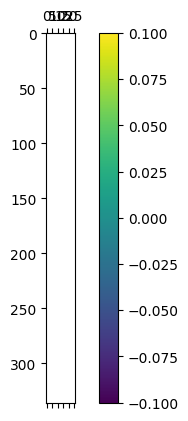

In [16]:
fracture_subdomains = model.mdg.subdomains(dim=model.nd - 1)
# ad = model.normal_fracture_deformation_equation(fracture_subdomains)
ad = model.tangential_fracture_deformation_equation(fracture_subdomains)
jac = ad.value_and_jacobian(model.equation_system).jac

jac = jac.tocsr()
plot_mat(jac[:, 3092:3118], log=False)

Solve  took: 0.05
PETSc Converged Reason: -5


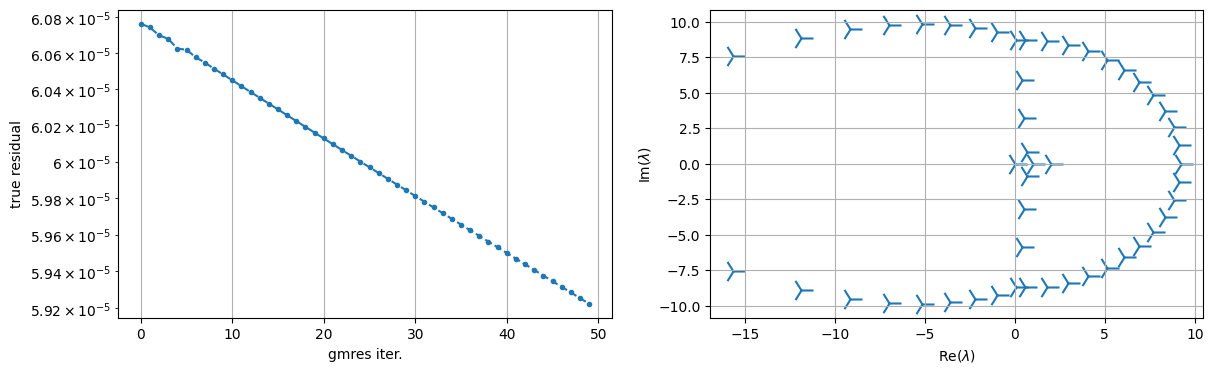

In [22]:
def pinv_left(mat):
    # A+ * A = I
    # Good for J54
    # Lin. indep. columns
    return inv(mat.T * mat) * mat.T


def pinv_right(mat):
    # A * A+ = I
    # Good for J45
    # Lin. indep. rows
    return mat.T * inv(mat * mat.T)


from scipy.sparse import csr_matrix

# def inv_or_0(block_matrices):
#     result = []
#     for bmat in block_matrices


def make_inv(
    J44: BlockMatrixStorage,
    J45: BlockMatrixStorage,
    J54: BlockMatrixStorage,
    J55: BlockMatrixStorage,
):
    return bmat(
        [
            [csr_matrix(J44.shape), pinv_left(J54.mat)],
            [csr_matrix(J54.shape), inv(J55.mat)]
        ]
    ).tocsr()

tmp = make_inv(J[4, 4], J[4,5], J[5,4], J[5,5])

solve_petsc(J[[4,5]].mat, tmp, J[[4,5]].local_rhs(rhs))

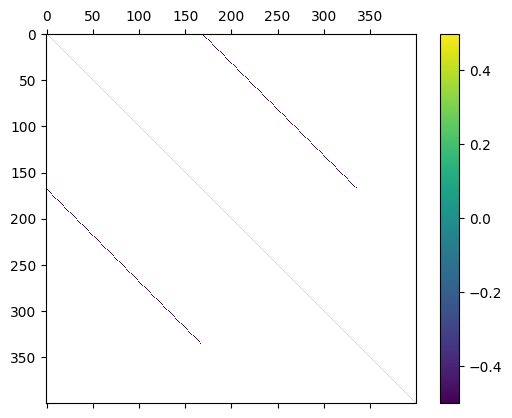

In [23]:
J54_inv = pinv_left(J54.mat)
plot_mat((J54.mat @ J54_inv)[:400, :400], log=False)

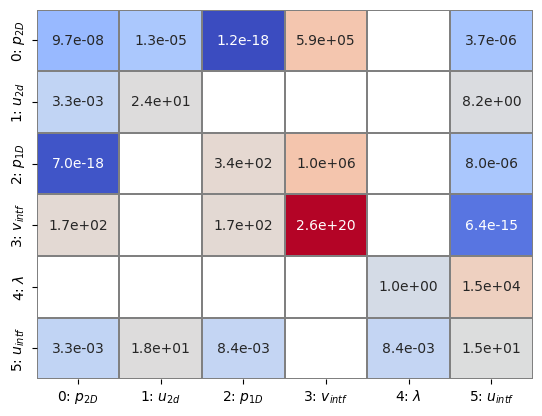

In [25]:
J[:].plot_max()